In [1]:
import sys
import os
import re
import pandas as p
from pydub import AudioSegment
import numpy as np
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import librosa
from sklearn.linear_model import Lasso
from sklearn.svm import SVC

import csv_combo
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
import random
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
def find_file(filenames, begin, end):
    """
    filenames: list of filenames
    begin: first number to look for in filename
    end: second number to look for in filename
    return: the first filename that contains both begin and end, or None if it doesn't exist
    """
    filenames = sorted(filenames)
    pattern = re.compile(r'.(\d+)-.(\d+)') # TODO only works with current filename formatting
    b_str = str(begin)
    e_str = str(end)
    for name in filenames:
        m = pattern.match(name)
        if m is None:
            continue
        if b_str == m.group(1) and e_str == m.group(2):
            return name
    return None

In [3]:
def get_begin_end(timepoint):
    """
    timepoint: string from timepoint column
    return: pair of ints (first timepoint in seconds, second timepoint in seconds)
    """
    print(timepoint)
    times = timepoint.split('-')
    assert len(times) == 2
    begintime = times[0]
    endtime = times[1]
    begintime_split = begintime.split(':')
    assert len(begintime_split) == 2
    if begintime_split[0] == "":
        begin = int(begintime_split[1])
    else:
        begin = 60 * int(begintime_split[0]) + int(begintime_split[1])
    endtime_split = endtime.split(':')
    assert len(endtime_split) == 2
    if endtime_split[0] == "":
        end = int(endtime_split[1])
    else:
        end = 60 * int(endtime_split[0]) + int(endtime_split[1])
    return begin, end

In [4]:
def augment_dataframes(spreadsheet_dict, datadir, filter=True):
    """
    spreadsheet_dict: dictionary loaded by get_all_spreadsheets
    datadir: directory containing subdirectories 'Codes' and 'Videos'
    filter: boolean. If True, only include rows with Mode 3, 15, or 18.

    return: nothing. This function mutates spreadsheet_dict by
    augmenting each dataframe to add the 'Audio Clip' column containing
    20-second audio snippets.
    """
    keys = list(spreadsheet_dict.keys())
    i = 0
    for excel_filename in keys:
        df = spreadsheet_dict[excel_filename]
        print('Now augmenting dataframe for', excel_filename)
        assert len(excel_filename) >= 8
        filename_prefix = excel_filename[:8]
        audios_dir = os.path.join(datadir, 'SplitVideos', filename_prefix)
        print('audios_dir:', audios_dir)
        audio_files = os.listdir(audios_dir)
        # Load file for each row, create new column, add that column
        mfccs = []
        debug = True
        j = 0
        for tp in df['Timepoint']:
            b, e = get_begin_end(tp)
            fname = find_file(audio_files, b, e)
            if debug:
                print('tp:', tp, '\tfname:', fname, '\tb:', b, '\te:', e)
            if fname is None:
                print('WARNING: file for "{}" is missing'.format(tp))
                mfccs_processed = None
            else:
                audio,sample_rate = librosa.load(os.path.join(audios_dir,fname),res_type="kaiser_fast")
                assert audio.shape == (441000,)
                
                #plt.figure(figsize=(12,4))
                #plt.plot(audio)
                #plt.show()
                #print(df['Mode'][j])
                
                mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=20)
                assert mfcc.shape == (20, 862)
                mfccs_processed = np.mean(mfcc.T,axis=0)
                assert mfccs_processed.shape == (20,)

                j += 1
            mfccs.append(mfccs_processed)

        df['Avg MFCC'] = mfccs
        print('Number of rows:', df.shape[0])
        print('len(mfccs):', len(mfccs))
        assert df.shape[0] == len(mfccs)
        if filter:
            print('Filtering by mode: 3, 15, or 18')
            df_filtered = df[df['Mode'].isin([3, 15, 18])]
            print('Number of rows:', df_filtered.shape[0])
        else:
            df_filtered = df
        
        spreadsheet_dict[excel_filename] = df_filtered
        i += 1



In [5]:
def load_and_augment_data(datadir):
    """
    This is the primary function to perform data loading and cleaning.

    datadir: dir containing subdirectories 'Videos' and 'Codes', as well as 'SplitVideos'
    return: a spreadsheet_dict object augmented by augment_dataframes
    """
    
    spreadsheet_dict = csv_combo.get_all_spreadsheets(datadir)
    print(len(spreadsheet_dict))
    augment_dataframes(spreadsheet_dict, datadir)
    return spreadsheet_dict

In [6]:
df = load_and_augment_data("TBOP coding samples")


21
Now augmenting dataframe for 60331_R2_With time.xlsx
audios_dir: TBOP coding samples/SplitVideos/60331_R2
:00-:20
tp: :00-:20 	fname: _0-_20.wav 	b: 0 	e: 20
:20-:40
tp: :20-:40 	fname: _20-_40.wav 	b: 20 	e: 40
:40-1:00
tp: :40-1:00 	fname: _40-_60.wav 	b: 40 	e: 60
1:00 - 1:20
tp: 1:00 - 1:20 	fname: _60-_80.wav 	b: 60 	e: 80
1:20-1:40
tp: 1:20-1:40 	fname: _80-_100.wav 	b: 80 	e: 100
1:40-2:00
tp: 1:40-2:00 	fname: _100-_120.wav 	b: 100 	e: 120
2:00 - 2:20
tp: 2:00 - 2:20 	fname: _120-_140.wav 	b: 120 	e: 140
2:20-2:40
tp: 2:20-2:40 	fname: _140-_160.wav 	b: 140 	e: 160
2:40-3:00
tp: 2:40-3:00 	fname: _160-_180.wav 	b: 160 	e: 180
3:00 - 3:20
tp: 3:00 - 3:20 	fname: _180-_200.wav 	b: 180 	e: 200
3:20-3:40
tp: 3:20-3:40 	fname: _200-_220.wav 	b: 200 	e: 220
3:40-4:00
tp: 3:40-4:00 	fname: _220-_240.wav 	b: 220 	e: 240
4:00 - 4:20
tp: 4:00 - 4:20 	fname: _240-_260.wav 	b: 240 	e: 260
4:20-4:40
tp: 4:20-4:40 	fname: _260-_280.wav 	b: 260 	e: 280
4:40-5:00
tp: 4:40-5:00 	fname: _280-

34:00-34:20
tp: 34:00-34:20 	fname: _2040-_2060.wav 	b: 2040 	e: 2060
34:20-34:40
tp: 34:20-34:40 	fname: _2060-_2080.wav 	b: 2060 	e: 2080
34:40-35:00
tp: 34:40-35:00 	fname: _2080-_2100.wav 	b: 2080 	e: 2100
Number of rows: 60
len(mfccs): 60
Filtering by mode: 3, 15, or 18
Number of rows: 41
Now augmenting dataframe for 20532_R3_With time.xlsx
audios_dir: TBOP coding samples/SplitVideos/20532_R3
5:00-5:20
tp: 5:00-5:20 	fname: _300-_320.wav 	b: 300 	e: 320
5:20-5:40
tp: 5:20-5:40 	fname: _320-_340.wav 	b: 320 	e: 340
5:40-6:00
tp: 5:40-6:00 	fname: _340-_360.wav 	b: 340 	e: 360
6:00 - 6:20
tp: 6:00 - 6:20 	fname: _360-_380.wav 	b: 360 	e: 380
6:20-6:40
tp: 6:20-6:40 	fname: _380-_400.wav 	b: 380 	e: 400
6:40-7:00
tp: 6:40-7:00 	fname: _400-_420.wav 	b: 400 	e: 420
7:00 - 7:20
tp: 7:00 - 7:20 	fname: _420-_440.wav 	b: 420 	e: 440
7:20-7:40
tp: 7:20-7:40 	fname: _440-_460.wav 	b: 440 	e: 460
7:40-8:00
tp: 7:40-8:00 	fname: _460-_480.wav 	b: 460 	e: 480
8:00 - 8:20
tp: 8:00 - 8:20 	fnam

33:00-33:20
tp: 33:00-33:20 	fname: _1980-_2000.wav 	b: 1980 	e: 2000
33:32-33:40
tp: 33:32-33:40 	fname: None 	b: 2012 	e: 2020
33:40-34:00
tp: 33:40-34:00 	fname: _2020-_2040.wav 	b: 2020 	e: 2040
34:00-34:20
tp: 34:00-34:20 	fname: _2040-_2060.wav 	b: 2040 	e: 2060
34:20-34:40
tp: 34:20-34:40 	fname: _2060-_2080.wav 	b: 2060 	e: 2080
34:40-35:00
tp: 34:40-35:00 	fname: _2080-_2100.wav 	b: 2080 	e: 2100
Number of rows: 60
len(mfccs): 60
Filtering by mode: 3, 15, or 18
Number of rows: 37
Now augmenting dataframe for 90132_R1 With time.xlsx
audios_dir: TBOP coding samples/SplitVideos/90132_R1
:00-:20
tp: :00-:20 	fname: _0-_20.wav 	b: 0 	e: 20
:20-:40
tp: :20-:40 	fname: _20-_40.wav 	b: 20 	e: 40
:40-1:00
tp: :40-1:00 	fname: _40-_60.wav 	b: 40 	e: 60
1:00 - 1:20
tp: 1:00 - 1:20 	fname: _60-_80.wav 	b: 60 	e: 80
1:20-1:40
tp: 1:20-1:40 	fname: _80-_100.wav 	b: 80 	e: 100
1:40-2:00
tp: 1:40-2:00 	fname: _100-_120.wav 	b: 100 	e: 120
2:00 - 2:20
tp: 2:00 - 2:20 	fname: _120-_140.wav 	b: 

31:40-32:00
tp: 31:40-32:00 	fname: _1900-_1920.wav 	b: 1900 	e: 1920
32:00-32:20
tp: 32:00-32:20 	fname: _1920-_1940.wav 	b: 1920 	e: 1940
32:20-32:40
tp: 32:20-32:40 	fname: _1940-_1960.wav 	b: 1940 	e: 1960
32:40-33:00
tp: 32:40-33:00 	fname: _1960-_1980.wav 	b: 1960 	e: 1980
33:00-33:20
tp: 33:00-33:20 	fname: _1980-_2000.wav 	b: 1980 	e: 2000
33:32-33:40
tp: 33:32-33:40 	fname: None 	b: 2012 	e: 2020
33:40-34:00
tp: 33:40-34:00 	fname: _2020-_2040.wav 	b: 2020 	e: 2040
34:00-34:20
tp: 34:00-34:20 	fname: _2040-_2060.wav 	b: 2040 	e: 2060
34:20-34:40
tp: 34:20-34:40 	fname: _2060-_2080.wav 	b: 2060 	e: 2080
34:40-35:00
tp: 34:40-35:00 	fname: _2080-_2100.wav 	b: 2080 	e: 2100
Number of rows: 60
len(mfccs): 60
Filtering by mode: 3, 15, or 18
Number of rows: 59
Now augmenting dataframe for 91132_R3_With time.xlsx
audios_dir: TBOP coding samples/SplitVideos/91132_R3
:00-:20
tp: :00-:20 	fname: _0-_20.wav 	b: 0 	e: 20
:20-:40
tp: :20-:40 	fname: _20-_40.wav 	b: 20 	e: 40
:40-1:00
tp: :

30:30-30:40
tp: 30:30-30:40 	fname: None 	b: 1830 	e: 1840
30:40-31:00
tp: 30:40-31:00 	fname: _1840-_1860.wav 	b: 1840 	e: 1860
31:00-31:20
tp: 31:00-31:20 	fname: _1860-_1880.wav 	b: 1860 	e: 1880
31:20-31:40
tp: 31:20-31:40 	fname: _1880-_1900.wav 	b: 1880 	e: 1900
31:40-32:00
tp: 31:40-32:00 	fname: _1900-_1920.wav 	b: 1900 	e: 1920
32:00-32:20
tp: 32:00-32:20 	fname: _1920-_1940.wav 	b: 1920 	e: 1940
32:20-32:40
tp: 32:20-32:40 	fname: _1940-_1960.wav 	b: 1940 	e: 1960
32:40-33:00
tp: 32:40-33:00 	fname: _1960-_1980.wav 	b: 1960 	e: 1980
33:00-33:20
tp: 33:00-33:20 	fname: _1980-_2000.wav 	b: 1980 	e: 2000
33:32-33:40
tp: 33:32-33:40 	fname: None 	b: 2012 	e: 2020
33:40-34:00
tp: 33:40-34:00 	fname: _2020-_2040.wav 	b: 2020 	e: 2040
34:00-34:20
tp: 34:00-34:20 	fname: _2040-_2060.wav 	b: 2040 	e: 2060
34:20-34:40
tp: 34:20-34:40 	fname: _2060-_2080.wav 	b: 2060 	e: 2080
34:40-35:00
tp: 34:40-35:00 	fname: _2080-_2100.wav 	b: 2080 	e: 2100
Number of rows: 60
len(mfccs): 60
Filterin

23:40-24:00
tp: 23:40-24:00 	fname: _1420-_1440.wav 	b: 1420 	e: 1440
24:00-24:20
tp: 24:00-24:20 	fname: _1440-_1460.wav 	b: 1440 	e: 1460
24:20-24:40
tp: 24:20-24:40 	fname: _1460-_1480.wav 	b: 1460 	e: 1480
24:40-25:00
tp: 24:40-25:00 	fname: _1480-_1500.wav 	b: 1480 	e: 1500
30:00-30:20
tp: 30:00-30:20 	fname: _1800-_1820.wav 	b: 1800 	e: 1820
30:30-30:40
tp: 30:30-30:40 	fname: None 	b: 1830 	e: 1840
30:40-31:00
tp: 30:40-31:00 	fname: _1840-_1860.wav 	b: 1840 	e: 1860
31:00-31:20
tp: 31:00-31:20 	fname: _1860-_1880.wav 	b: 1860 	e: 1880
31:20-31:40
tp: 31:20-31:40 	fname: _1880-_1900.wav 	b: 1880 	e: 1900
31:40-32:00
tp: 31:40-32:00 	fname: _1900-_1920.wav 	b: 1900 	e: 1920
32:00-32:20
tp: 32:00-32:20 	fname: _1920-_1940.wav 	b: 1920 	e: 1940
32:20-32:40
tp: 32:20-32:40 	fname: _1940-_1960.wav 	b: 1940 	e: 1960
32:40-33:00
tp: 32:40-33:00 	fname: _1960-_1980.wav 	b: 1960 	e: 1980
33:00-33:20
tp: 33:00-33:20 	fname: _1980-_2000.wav 	b: 1980 	e: 2000
33:32-33:40
tp: 33:32-33:40 	fn

22:20-22:40
tp: 22:20-22:40 	fname: _1340-_1360.wav 	b: 1340 	e: 1360
22:40-23:00
tp: 22:40-23:00 	fname: _1360-_1380.wav 	b: 1360 	e: 1380
23:00-23:20
tp: 23:00-23:20 	fname: _1380-_1400.wav 	b: 1380 	e: 1400
23:20-23:40
tp: 23:20-23:40 	fname: _1400-_1420.wav 	b: 1400 	e: 1420
23:40-24:00
tp: 23:40-24:00 	fname: _1420-_1440.wav 	b: 1420 	e: 1440
24:00-24:20
tp: 24:00-24:20 	fname: _1440-_1460.wav 	b: 1440 	e: 1460
24:20-24:40
tp: 24:20-24:40 	fname: _1460-_1480.wav 	b: 1460 	e: 1480
24:40-25:00
tp: 24:40-25:00 	fname: _1480-_1500.wav 	b: 1480 	e: 1500
30:00-30:20
tp: 30:00-30:20 	fname: _1800-_1820.wav 	b: 1800 	e: 1820
30:30-30:40
tp: 30:30-30:40 	fname: None 	b: 1830 	e: 1840
30:40-31:00
tp: 30:40-31:00 	fname: _1840-_1860.wav 	b: 1840 	e: 1860
31:00-31:20
tp: 31:00-31:20 	fname: _1860-_1880.wav 	b: 1860 	e: 1880
31:20-31:40
tp: 31:20-31:40 	fname: _1880-_1900.wav 	b: 1880 	e: 1900
31:40-32:00
tp: 31:40-32:00 	fname: _1900-_1920.wav 	b: 1900 	e: 1920
32:00-32:20
tp: 32:00-32:20 	fn

20:40-21:00
tp: 20:40-21:00 	fname: _1240-_1260.wav 	b: 1240 	e: 1260
21:00-21:20
tp: 21:00-21:20 	fname: _1260-_1280.wav 	b: 1260 	e: 1280
21:20-21:40
tp: 21:20-21:40 	fname: _1280-_1300.wav 	b: 1280 	e: 1300
21:40-22:00
tp: 21:40-22:00 	fname: _1300-_1320.wav 	b: 1300 	e: 1320
22:00-22:20
tp: 22:00-22:20 	fname: _1320-_1340.wav 	b: 1320 	e: 1340
22:20-22:40
tp: 22:20-22:40 	fname: _1340-_1360.wav 	b: 1340 	e: 1360
22:40-23:00
tp: 22:40-23:00 	fname: _1360-_1380.wav 	b: 1360 	e: 1380
23:00-23:20
tp: 23:00-23:20 	fname: _1380-_1400.wav 	b: 1380 	e: 1400
23:20-23:40
tp: 23:20-23:40 	fname: _1400-_1420.wav 	b: 1400 	e: 1420
23:40-24:00
tp: 23:40-24:00 	fname: _1420-_1440.wav 	b: 1420 	e: 1440
24:00-24:20
tp: 24:00-24:20 	fname: _1440-_1460.wav 	b: 1440 	e: 1460
24:20-24:40
tp: 24:20-24:40 	fname: _1460-_1480.wav 	b: 1460 	e: 1480
24:40-25:00
tp: 24:40-25:00 	fname: _1480-_1500.wav 	b: 1480 	e: 1500
30:00-30:20
tp: 30:00-30:20 	fname: _1800-_1820.wav 	b: 1800 	e: 1820
30:30-30:40
tp: 30:3

14:20-14:40
tp: 14:20-14:40 	fname: _860-_880.wav 	b: 860 	e: 880
14:40-15:00
tp: 14:40-15:00 	fname: _880-_900.wav 	b: 880 	e: 900
20:00-20:20
tp: 20:00-20:20 	fname: _1200-_1220.wav 	b: 1200 	e: 1220
20:20-20:40
tp: 20:20-20:40 	fname: _1220-_1240.wav 	b: 1220 	e: 1240
20:40-21:00
tp: 20:40-21:00 	fname: _1240-_1260.wav 	b: 1240 	e: 1260
21:00-21:20
tp: 21:00-21:20 	fname: _1260-_1280.wav 	b: 1260 	e: 1280
21:20-21:40
tp: 21:20-21:40 	fname: _1280-_1300.wav 	b: 1280 	e: 1300
21:40-22:00
tp: 21:40-22:00 	fname: _1300-_1320.wav 	b: 1300 	e: 1320
22:00-22:20
tp: 22:00-22:20 	fname: _1320-_1340.wav 	b: 1320 	e: 1340
22:20-22:40
tp: 22:20-22:40 	fname: _1340-_1360.wav 	b: 1340 	e: 1360
22:40-23:00
tp: 22:40-23:00 	fname: _1360-_1380.wav 	b: 1360 	e: 1380
23:00-23:20
tp: 23:00-23:20 	fname: _1380-_1400.wav 	b: 1380 	e: 1400
23:20-23:40
tp: 23:20-23:40 	fname: _1400-_1420.wav 	b: 1400 	e: 1420
23:40-24:00
tp: 23:40-24:00 	fname: _1420-_1440.wav 	b: 1420 	e: 1440
24:00-24:20
tp: 24:00-24:20 

12:40-13:00
tp: 12:40-13:00 	fname: _760-_780.wav 	b: 760 	e: 780
13:00 - 13:20
tp: 13:00 - 13:20 	fname: _780-_800.wav 	b: 780 	e: 800
13:20-13:40
tp: 13:20-13:40 	fname: _800-_820.wav 	b: 800 	e: 820
13:40-14:00
tp: 13:40-14:00 	fname: _820-_840.wav 	b: 820 	e: 840
14:00 - 14:20
tp: 14:00 - 14:20 	fname: _840-_860.wav 	b: 840 	e: 860
14:20-14:40
tp: 14:20-14:40 	fname: _860-_880.wav 	b: 860 	e: 880
14:40-15:00
tp: 14:40-15:00 	fname: _880-_900.wav 	b: 880 	e: 900
20:00-20:20
tp: 20:00-20:20 	fname: _1200-_1220.wav 	b: 1200 	e: 1220
20:20-20:40
tp: 20:20-20:40 	fname: _1220-_1240.wav 	b: 1220 	e: 1240
20:40-21:00
tp: 20:40-21:00 	fname: _1240-_1260.wav 	b: 1240 	e: 1260
21:00-21:20
tp: 21:00-21:20 	fname: _1260-_1280.wav 	b: 1260 	e: 1280
21:20-21:40
tp: 21:20-21:40 	fname: _1280-_1300.wav 	b: 1280 	e: 1300
21:40-22:00
tp: 21:40-22:00 	fname: _1300-_1320.wav 	b: 1300 	e: 1320
22:00-22:20
tp: 22:00-22:20 	fname: _1320-_1340.wav 	b: 1320 	e: 1340
22:20-22:40
tp: 22:20-22:40 	fname: _134

11:20-11:40
tp: 11:20-11:40 	fname: _680-_700.wav 	b: 680 	e: 700
11:40-12:00
tp: 11:40-12:00 	fname: _700-_720.wav 	b: 700 	e: 720
12:00 - 12:20
tp: 12:00 - 12:20 	fname: _720-_740.wav 	b: 720 	e: 740
12:20-12:40
tp: 12:20-12:40 	fname: _740-_760.wav 	b: 740 	e: 760
12:40-13:00
tp: 12:40-13:00 	fname: _760-_780.wav 	b: 760 	e: 780
13:00 - 13:20
tp: 13:00 - 13:20 	fname: _780-_800.wav 	b: 780 	e: 800
13:20-13:40
tp: 13:20-13:40 	fname: _800-_820.wav 	b: 800 	e: 820
13:40-14:00
tp: 13:40-14:00 	fname: _820-_840.wav 	b: 820 	e: 840
14:00 - 14:20
tp: 14:00 - 14:20 	fname: _840-_860.wav 	b: 840 	e: 860
14:20-14:40
tp: 14:20-14:40 	fname: _860-_880.wav 	b: 860 	e: 880
14:40-15:00
tp: 14:40-15:00 	fname: _880-_900.wav 	b: 880 	e: 900
20:00-20:20
tp: 20:00-20:20 	fname: _1200-_1220.wav 	b: 1200 	e: 1220
20:20-20:40
tp: 20:20-20:40 	fname: _1220-_1240.wav 	b: 1220 	e: 1240
20:40-21:00
tp: 20:40-21:00 	fname: _1240-_1260.wav 	b: 1240 	e: 1260
21:00-21:20
tp: 21:00-21:20 	fname: _1260-_1280.wav 

In [7]:
# Combining all the dataframes for each file into one large dataframe
i = 0
for key in df.keys():
    print('Number of rows in single dataframe:', df[key].shape[0])
    if i == 0:
        one_big_df = df[key].drop(['Timepoint','District ID', 'School ID', 'Teacher ID', 'Condition', 'Obs. Entry', 'ESL Strategy', 'Curriculum',
             'Physical Group', 'Activity Structure', 'Language Content', 'Lang. of Instruction(T)',
             'Lang. of Instruction(S)', 'Round'],axis=1)
    else:
        data = df[key].drop(['Timepoint','District ID', 'School ID', 'Teacher ID', 'Condition', 'Obs. Entry', 'ESL Strategy', 'Curriculum',
             'Physical Group', 'Activity Structure', 'Language Content', 'Lang. of Instruction(T)',
             'Lang. of Instruction(S)', 'Round'],axis=1)
        one_big_df = p.concat([one_big_df,data])
    i += 1
print('Number of rows in combined dataframe:', one_big_df.shape[0])
labels_binary = [(1 if label == 3 else 0) for label in one_big_df['Mode'].tolist()]
print(len(labels_binary))

print(one_big_df.head(5))
print(labels_binary[:5]) # labels_binary is unused elsewhere

Number of rows in single dataframe: 46
Number of rows in single dataframe: 41
Number of rows in single dataframe: 60
Number of rows in single dataframe: 37
Number of rows in single dataframe: 58
Number of rows in single dataframe: 59
Number of rows in single dataframe: 59
Number of rows in single dataframe: 58
Number of rows in single dataframe: 60
Number of rows in single dataframe: 54
Number of rows in single dataframe: 59
Number of rows in single dataframe: 57
Number of rows in single dataframe: 56
Number of rows in single dataframe: 60
Number of rows in single dataframe: 41
Number of rows in single dataframe: 58
Number of rows in single dataframe: 60
Number of rows in single dataframe: 38
Number of rows in single dataframe: 30
Number of rows in single dataframe: 54
Number of rows in single dataframe: 44
Number of rows in combined dataframe: 1089
1089
   Mode                                           Avg MFCC
2  18.0  [-372.21185, 126.285194, -37.474392, 31.811068...
4   3.0  [-423.

In [8]:
# Extracting the features and preparing them for a ML Model
df_nonnull = one_big_df[~one_big_df['Avg MFCC'].isnull()]
print('Number of rows remaining after filtering null values:', df_nonnull.shape[0])
#audios = df_nonnull["Audio Clip"]
#energies = df_nonnull["Energy"]
mfccs = df_nonnull["Avg MFCC"]
labels = df_nonnull['Mode'].tolist()
yy = [(1 if label == 3 else 0) for label in labels]
df_nonnull = df_nonnull.drop(['Mode'],axis=1)
#audios = [np.array(a) for a in df_nonnull['Audio Clip']]
#audios = np.array(audios)
#energies = [np.array(a) for a in df_nonnull['Energy']]
#energies = np.array(energies)
mfccs = [np.array(a) for a in df_nonnull['Avg MFCC']]
mfccs = np.array(mfccs)
print(mfccs.shape)
#audios = audios.reshape(-1,1)
#print(type(audios))

Number of rows remaining after filtering null values: 1052
(1052, 20)


In [9]:
"""train_X,test_X,train_Y,test_Y = train_test_split(mfccs,yy,test_size=0.1,random_state=random.randint(0,100))
accuracy_scores = []
iterations = []"""

'train_X,test_X,train_Y,test_Y = train_test_split(mfccs,yy,test_size=0.1,random_state=random.randint(0,100))\naccuracy_scores = []\niterations = []'

In [10]:
# # Running a RFC with 1000 estimators on 10 different randomly selected test and training sets
# accuracy_scores = []
# iterations = []
# for i in range(25):
#     train_X,test_X,train_Y,test_Y = train_test_split(mfccs,yy,test_size=0.05,random_state=random.randint(0,100))
    
#     model = RandomForestClassifier(n_estimators=1000,max_features="sqrt",min_samples_leaf=1)
#     model.fit(train_X,train_Y)
#     pred_Y = model.predict(test_X)
#     print(pred_Y)
#     print("Accuracy: " + str(accuracy_score(test_Y,pred_Y)))
#     accuracy_scores.append(accuracy_score(test_Y,pred_Y))
#     iterations.append(i)

# print("Average Accuracy: " + str(sum(accuracy_scores)/10))

In [11]:
# # Graphing the results
# plt.plot(iterations,accuracy_scores,'.-')
# plt.xlabel("Iteration")
# plt.ylabel("Accuracy of Model (%)")
# plt.show()
# print("Average Accuracy: " + str(sum(accuracy_scores)/25))

In [12]:
models = ["RFC","LR","PCA + LR","KNN","SVC","MLP"]
accuracies = []
train_X,test_X,train_Y,test_Y = train_test_split(mfccs,yy,test_size=0.1,random_state=123)
    # Random Forest
model = RandomForestClassifier(n_estimators=1000)
model.fit(train_X,train_Y)
pred_Y_rfc = model.predict(test_X)
accuracies.append(accuracy_score(test_Y,pred_Y_rfc))

    #LR
model = LR()
model.fit(train_X,train_Y)
pred_Y_lr = model.predict(test_X)
accuracies.append(accuracy_score(test_Y,pred_Y_lr))
    #PCA + LR
pca_model = PCA(n_components=5)
lr_model = LR()
train_reduced = pca_model.fit_transform(train_X)
test_reduced = pca_model.transform(test_X)
lr_model.fit(train_reduced,train_Y)
pred_Y_pcalr = lr_model.predict(test_reduced)
accuracies.append(accuracy_score(test_Y,pred_Y_pcalr))   
    #KNN
model = KNeighborsClassifier(n_neighbors=5)
model.fit(train_X,train_Y)
pred_Y_knn = model.predict(test_X)
accuracies.append(accuracy_score(test_Y,pred_Y_knn))   
    #SVC
model = SVC()
model.fit(train_X,train_Y)
pred_Y_svc = model.predict(test_X)
accuracies.append(accuracy_score(test_Y,pred_Y_svc))  

    #MLPClassifier
model = MLPClassifier()
model.fit(train_X,train_Y)
pred_Y_mlp = model.predict(test_X)
accuracies.append(accuracy_score(test_Y,pred_Y_mlp))


print(accuracies,models)

/home/successlab/miniconda3/envs/octonet/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[0.660377358490566, 0.5849056603773585, 0.5, 0.6037735849056604, 0.5660377358490566, 0.6415094339622641] ['RFC', 'LR', 'PCA + LR', 'KNN', 'SVC', 'MLP']


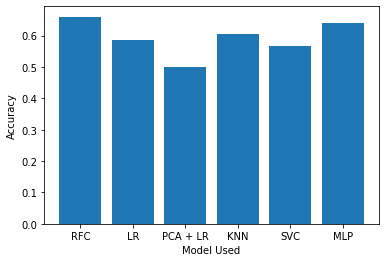

In [13]:
x_pos = [i for i, _ in enumerate(models)]

plt.bar(x_pos,accuracies)
plt.xlabel("Model Used")
plt.ylabel("Accuracy")
plt.xticks(x_pos, models)
plt.show()

Confusion matrix:
[[35 19]
 [17 35]]


<AxesSubplot:>

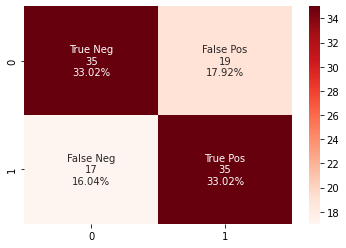

In [14]:

results = confusion_matrix(test_Y,pred_Y_rfc)
print('Confusion matrix:', results, sep='\n')
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                results.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     results.flatten()/np.sum(results)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(results, annot=labels, fmt='', cmap='Reds')